In [2]:
import lifesim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib
from matplotlib.lines import Line2D

### Import the catalog in Lay configuration with paper I occurrence statistics

In [3]:
bus_0 = lifesim.Bus()
bus_0.build_from_config(filename='/home/ipa/quanz/user_accounts/fdannert/noise_paper_23/70_results/S01_Lay/'
                        'S01_base_bryson_hab2high.yaml')

bus_0.data.import_catalog(input_path='/home/ipa/quanz/user_accounts/fdannert/noise_paper_23/70_results/S01_Lay/'
                                   'S01_base_bryson_hab2high_catalog.hdf5',
                        noise_catalog=True)

ana = lifesim.SampleAnalysisModule(name='ana')
bus_0.add_module(ana)

ana.get_fundamental_snr()

opt_0 = lifesim.Optimizer(name='opt_0')
bus_0.add_module(opt_0)
ahgs_0 = lifesim.AhgsModule(name='ahgs_0')
bus_0.add_module(ahgs_0)

bus_0.connect(('opt_0', 'ahgs_0'))
opt_0.ahgs()

Importing Catalog...
Beginning Import...
Import completed (Time: 0.4807400703430176), changing string object types...
[Done] (Time: 0.019131898880004883)
Importing Noise Catalog...
[Done]
Number of planets detected by stellar type:
A: 0.0  F: 5.196  G: 4.938  K: 10.226  M: 0.0  -  (2.0 / 2.0) yrs observed


In [4]:
bus_1 = lifesim.Bus()
bus_1.build_from_config(filename='/home/ipa/quanz/user_accounts/fdannert/noise_paper_23/70_results/S01_Lay/'
                        'S01_base_bryson_hab2high.yaml')

bus_1.data.import_catalog(input_path='/home/ipa/quanz/user_accounts/fdannert/noise_paper_23/70_results/S01_Lay/'
                                   'S01_base_bryson_hab2high_catalog.hdf5',
                        noise_catalog=True)

bus_1.data.options.set_manual(instrumental_opt=True)
opt_1 = lifesim.Optimizer(name='opt_1')
bus_1.add_module(opt_1)
ahgs_1 = lifesim.AhgsModule(name='ahgs_1')
bus_1.add_module(ahgs_1)

bus_1.connect(('opt_1', 'ahgs_1'))
opt_1.ahgs()

Importing Catalog...
Beginning Import...
Import completed (Time: 0.1468524932861328), changing string object types...
[Done] (Time: 0.018189191818237305)
Importing Noise Catalog...
[Done]
Number of planets detected by stellar type:
A: 0.0  F: 0.0  G: 0.018  K: 2.824  M: 0.0  -  (2.0 / 2.0) yrs observed


### Create the star catalog

In [5]:
np.sum(bus_0.data.catalog.detected[bus_0.data.catalog.nstar == 5])

402

In [6]:
bus_0.data.catalog.detected[bus_0.data.catalog.nstar == 5].shape[0]

489

In [7]:
star_catalog = {}
n_universe = np.unique(bus_0.data.catalog.nuniverse).shape[0]

for sn in tqdm(np.unique(bus_0.data.catalog.nstar)):
    star_ex = bus_0.data.catalog[bus_0.data.catalog.nstar == sn]
    star_ex_inst = bus_1.data.catalog[bus_1.data.catalog.nstar == sn]
    star = star_ex.iloc[0]
    
    star_catalog[star.name_s] = {'radius_s': star.radius_s,
                                 'mass_s' : star.mass_s, 
                                 'temp_s': star.temp_s, 
                                 'distance_s': star.distance_s,
                                 'ra': star.ra, 
                                 'dec': star.dec,
                                 'stype': star.stype,
                                 'l_sun': star.l_sun,
                                }
    
    star_catalog[star.name_s]['no_detections_base'] = np.sum(star_ex.detected)/n_universe
    star_catalog[star.name_s]['no_detections_inst'] = np.sum(star_ex_inst.detected)/n_universe
    
    star_catalog[star.name_s]['completeness_base'] = np.sum(star_ex.detected)/star_ex.detected.shape[0]
    star_catalog[star.name_s]['completeness_inst'] = np.sum(star_ex_inst.detected)/star_ex_inst.detected.shape[0]
    
    #detections = []
    #completeness = []
    #for nu in star_ex.nuniverse:
    #    detections.append(np.sum(star_ex.detected[star_ex.nuniverse == nu]))
    #    completeness.append(np.sum(star_ex.detected[star_ex.nuniverse == nu])
    #                       / star_ex.detected[star_ex.nuniverse == nu].shape[0])
    #detections = np.array(detections)
    #completeness = np.array(completeness)
    
    '''
    fig, ax = plt.subplots(ncols=2)
    ax[0].hist(detections)
    ax[0].set_title('detections')
    ax[1].hist(completeness)
    ax[1].set_title('completeness')
    plt.show()
    '''
    
    #star_catalog[star.name_s]['no_detections_base_unc'] = np.std(detections)
    #star_catalog[star.name_s]['completeness_base_unc'] = np.std(completeness)
    
star_catalog = pd.DataFrame(star_catalog).T

100%|████████████████████████████████████████████████████████████████████████████████████████████| 358/358 [00:00<00:00, 689.78it/s]


In [8]:
star_catalog['d_completeness'] = - star_catalog.completeness_base + star_catalog.completeness_inst

In [9]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [58]:
customPalette = sns.diverging_palette(42, 230, l=70, as_cmap=True, center='dark', sep=1)
#141

customPalette = shiftedColorMap(customPalette, midpoint=0.8, name='shifted16')

/tmp/ipykernel_1315723/836158580.py:48: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=newcmap)


In [59]:
significant = 0.2

star_catalog['not_observed'] = np.logical_and(star_catalog.completeness_base != 0,
                                              star_catalog.completeness_inst == 0.)
star_catalog['new_observed'] = np.logical_and(star_catalog.completeness_base == 0,
                                              star_catalog.completeness_inst != 0.)
star_catalog['sig_decrease'] = (star_catalog.d_completeness > significant)
star_catalog['sig_increase'] = (star_catalog.d_completeness < -significant)
star_catalog['same'] = np.logical_and((np.abs(star_catalog.d_completeness) < significant),
                                     star_catalog.completeness_base != 0)

In [60]:
mask = np.logical_and.reduce((star_catalog.d_completeness != 0,
                             np.invert(star_catalog.not_observed),
                             np.invert(star_catalog.new_observed)))


/tmp/ipykernel_1315723/3738109954.py:58: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm, label='$\Delta$ Completeness')


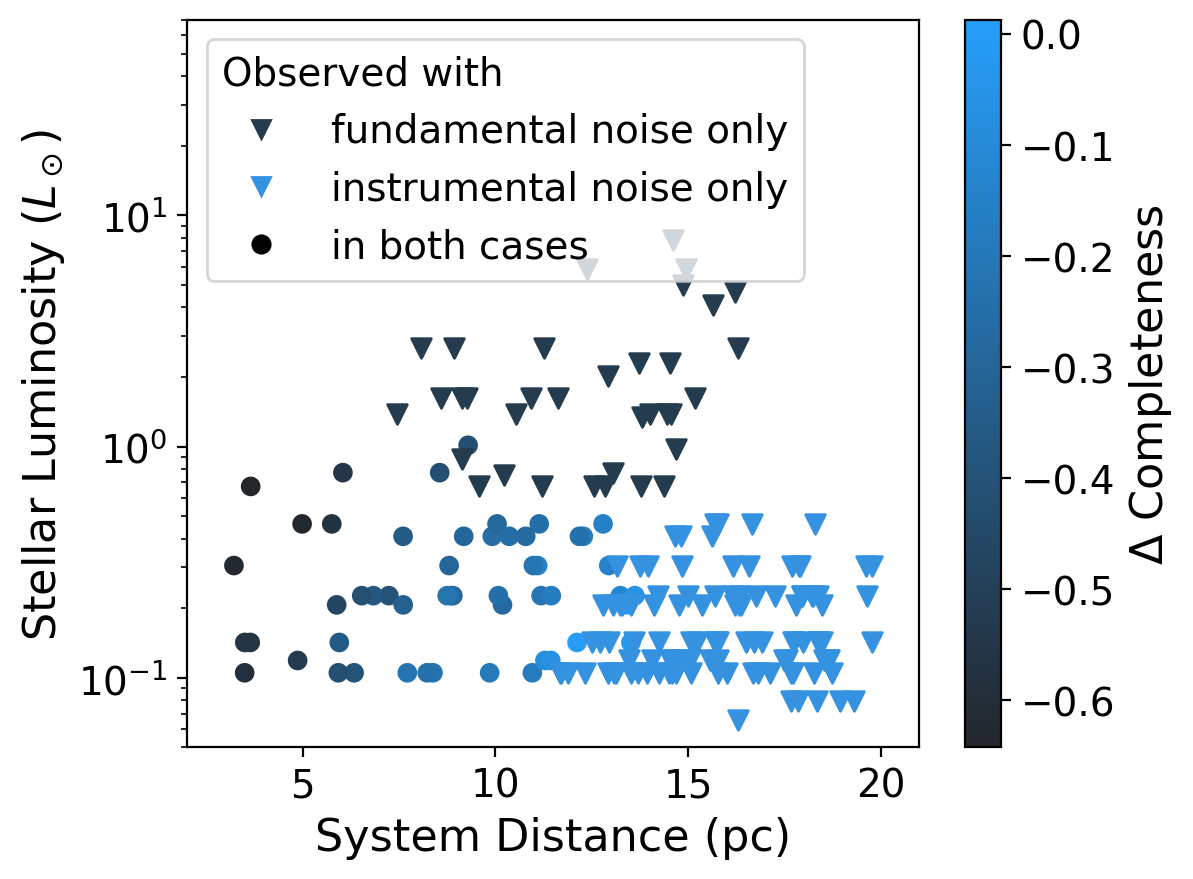

In [84]:
color = ['#269FFB', '#ECA86E']
color = ['#253B4E', '#3492E0']

small_size = 14
medium_size = 16
large_size = 18

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=medium_size)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(15*0.393701, 12*0.393701), dpi=200)
# sns.despine(f, left=True, bottom=True)
# clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

norm = plt.Normalize(star_catalog[mask].d_completeness.min(), 
                     star_catalog[mask].d_completeness.max())
colors = [[norm(-0.6), '#269FFB'],
          [norm(0.), 'k'],]

cmap = sns.dark_palette('#269FFB', reverse=False, as_cmap=True)

plot_x = 'distance_s'
plot_y = 'l_sun'
plot_hue = 'd_completeness'

size=50

sns.scatterplot(x=plot_x, y=plot_y,
                hue=plot_hue,
                palette=cmap,
                hue_norm=norm,
                #hue_order=clarity_ranking,
                sizes=(1, 8), linewidth=0,
                data=star_catalog[mask], 
                ax=ax,
                s=size)

ax.scatter(star_catalog[star_catalog.not_observed][plot_x], 
               star_catalog[star_catalog.not_observed][plot_y], 
               c=color[0], marker='v', s=size)
ax.scatter(star_catalog[star_catalog.new_observed][plot_x], 
               star_catalog[star_catalog.new_observed][plot_y], 
               c=color[1], marker='v', s=size)

# Remove the legend and add a colorbar
#ax.get_legend().remove()
norm = plt.Normalize(star_catalog[mask][plot_hue].min(), star_catalog[mask][plot_hue].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='$\Delta$ Completeness')

legend_elements = [Line2D([0], [0], marker='v', color=color[0], label='fundamental noise only',
                          markerfacecolor=color[0], markersize=size/8, lw=0),
                   Line2D([0], [0], marker='v', color=color[1], label='instrumental noise only',
                          markerfacecolor=color[1], markersize=size/8, lw=0),
                   Line2D([0], [0], marker='o', color='k', label='in both cases',
                          markerfacecolor='k', markersize=size/8, lw=0),
                  ]

legend = ax.legend(handles=legend_elements, loc='upper left', title='Observed with', fontsize=small_size)

legend._legend_box.align = "left"

ax.set_yscale('log')
ax.set_xlim((2., 21))
ax.set_ylim((5e-2, 7e1))
ax.set_xlabel('System Distance (pc)')
ax.set_ylabel('Stellar Luminosity ($L_\odot$)')

plt.show()
#fig.savefig('/home/ipa/quanz/user_accounts/fdannert/noise_paper_23/50_code/InLIFEsim/docs/source/paper_experiments/figures/sample_comparison_lay.pdf', bbox_inches='tight')